In [11]:
import pandas as pd 
import numpy as np

import os
import sys

import librosa
import librosa.display 
import seaborn as sns
import matplotlib.pyplot as plt 

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

from IPython.display import Audio

import keras 
from keras.callbacks import ReduceLROnPlateau,TensorBoard,EarlyStopping
from keras.models import Sequential
from keras.layers import Dense, Conv1D,MaxPooling1D,Flatten,Dropout,BatchNormalization
from keras.utils import np_utils
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint

import warnings 
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore",category=DeprecationWarning)


In [12]:
Features = pd.read_csv("features.csv")

In [13]:
X = Features.iloc[: ,:-1].values
Y = Features['labels'].values

In [14]:
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [15]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((27364, 206), (27364, 8), (9122, 206), (9122, 8))

In [16]:
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((27364, 206), (27364, 8), (9122, 206), (9122, 8))

In [17]:
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((27364, 206, 1), (27364, 8), (9122, 206, 1), (9122, 8))

In [23]:
model = Sequential()
model.add(Conv1D(512, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(256, kernel_size=5, strides=1, padding="same", activation="relu"))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding="same"))

model.add(Conv1D(256,kernel_size=5,strides=1,padding="same",activation="relu",kernel_regularizer="l2"))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding="same"))
model.add(Dropout(0.5))

model.add(Conv1D(256,kernel_size=5,strides=1,padding="same",activation="relu",kernel_regularizer="l2"))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding="same"))


model.add(Conv1D(128, kernel_size=5, strides=1, padding="same", activation="relu"))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding="same"))
model.add(Dropout(0.5))
          
model.add(Conv1D(128,kernel_size=5,strides=1,padding="same",activation="relu"))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding="same"))
        
model.add(Flatten())
model.add(Dense(units=64,activation="relu",kernel_regularizer="l2"))
model.add(Dropout(0.3))
    
model.add(Dense(units=8,activation="softmax"))
        
          
model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_15 (Conv1D)           (None, 206, 512)          3072      
_________________________________________________________________
max_pooling1d_15 (MaxPooling (None, 103, 512)          0         
_________________________________________________________________
conv1d_16 (Conv1D)           (None, 103, 256)          655616    
_________________________________________________________________
max_pooling1d_16 (MaxPooling (None, 52, 256)           0         
_________________________________________________________________
conv1d_17 (Conv1D)           (None, 52, 256)           327936    
_________________________________________________________________
max_pooling1d_17 (MaxPooling (None, 26, 256)           0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 26, 256)          

In [24]:
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.3, verbose=0, patience=2, min_lr=0.001)
history=model.fit(x_train, y_train, batch_size=512, epochs=50, validation_data=(x_test, y_test), callbacks=[rlrp])

Epoch 1/50
54/54 [==============================] - 19s 298ms/step - loss: 5.6529 - accuracy: 0.2079 - val_loss: 2.2189 - val_accuracy: 0.2939
Epoch 2/50
54/54 [==============================] - 15s 278ms/step - loss: 2.0785 - accuracy: 0.2937 - val_loss: 1.8280 - val_accuracy: 0.3216
Epoch 3/50
54/54 [==============================] - 15s 278ms/step - loss: 1.7826 - accuracy: 0.3309 - val_loss: 1.6370 - val_accuracy: 0.3720
Epoch 4/50
54/54 [==============================] - 15s 278ms/step - loss: 1.6576 - accuracy: 0.3678 - val_loss: 1.5684 - val_accuracy: 0.4062
Epoch 5/50
54/54 [==============================] - 15s 278ms/step - loss: 1.5992 - accuracy: 0.3885 - val_loss: 1.5178 - val_accuracy: 0.4257
Epoch 6/50
54/54 [==============================] - 15s 279ms/step - loss: 1.5574 - accuracy: 0.4104 - val_loss: 1.4684 - val_accuracy: 0.4486
Epoch 7/50
54/54 [==============================] - 15s 278ms/step - loss: 1.5142 - accuracy: 0.4283 - val_loss: 1.4792 - val_accuracy: 0.4444

In [25]:
print("Accuracy of our model on test data : " , model.evaluate(x_test,y_test)[1]*100 , "%")

286/286 [==============================] - 3s 11ms/step - loss: 1.1655 - accuracy: 0.5839
Accuracy of our model on test data :  58.38631987571716 %


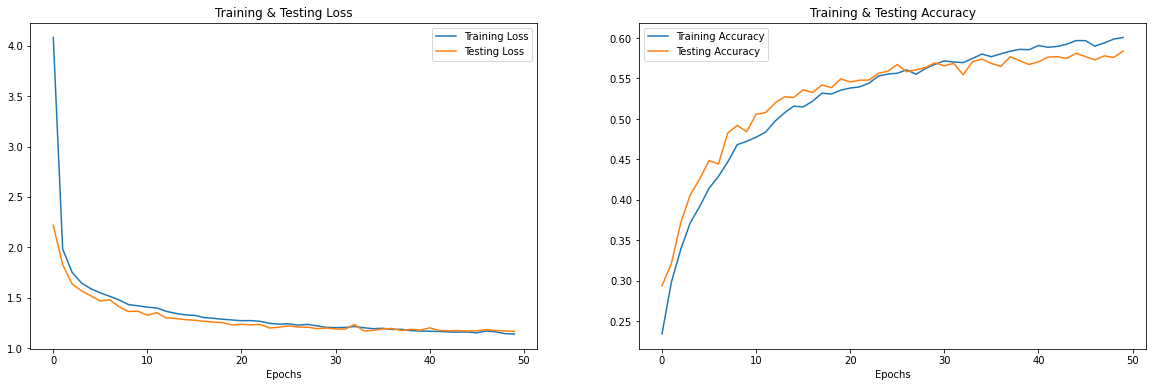

In [26]:
epochs = [i for i in range(50)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()